# Black-Scholes Model with Python

This notebook explores the Black-Scholes equation for pricing European call options.  
We'll derive its closed-form solution, analyze how its parameters affect the option price, and visualize it using Python.

> 💡 The Black-Scholes model helps determine the fair price of a call option under a no-arbitrage assumption, given market variables like volatility, interest rate, and time to maturity.


## 📘 Black-Scholes Formula: Closed-Form Solution

The value of a European call option is given by the famous Black-Scholes formula:

$$
C(S, t) = S \cdot N(d_1) - K e^{-r (T - t)} \cdot N(d_2)
$$

Where:

$$
d_1 = \frac{\ln(S / K) + (r + \frac{1}{2} \sigma^2)(T - t)}{\sigma \sqrt{T - t}}, \quad
d_2 = d_1 - \sigma \sqrt{T - t}
$$

- \( C(S, t) \): call option price  
- \( S \): current stock price  
- \( K \): strike price  
- \( T \): time to maturity  
- \( r \): risk-free interest rate  
- \( \sigma \): volatility  
- \( N(\cdot) \): CDF of standard normal distribution


## 🧪 Black-Scholes Formula in Python

We now implement the formula using NumPy and SciPy.

In [1]:
%cd ..
from black_scholes import BlackScholesPINN
import json
from utils import *
import matplotlib.pyplot as plt

with open("config.json") as f:
    config = json.load(f)

/Users/pieropaialunga/Desktop/MediumProject/PINN_Finance/BlackScholesPINN


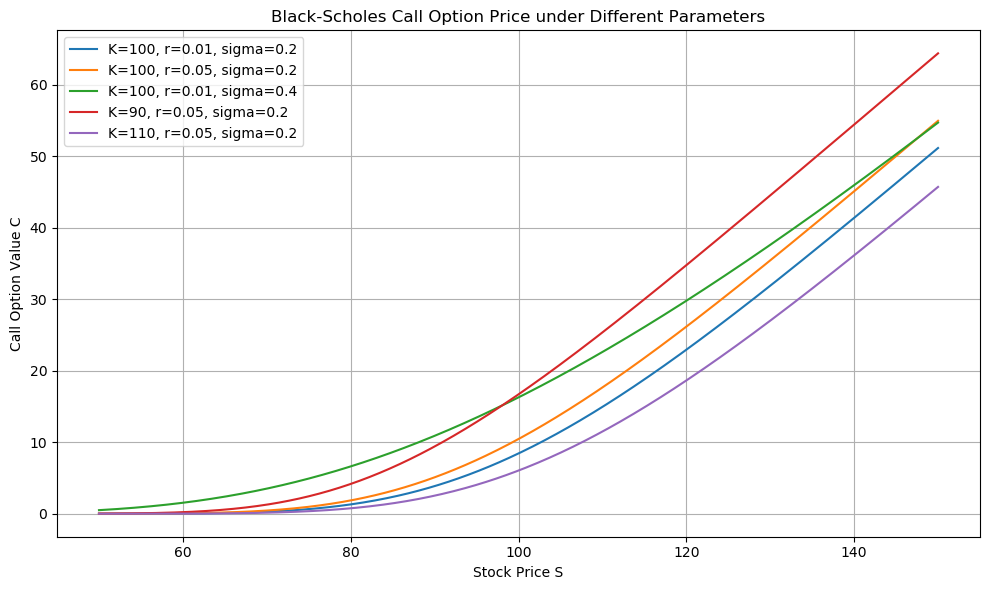

In [2]:

# Parameters for different cases
cases = [
    {"K": 100, "T": 1.0, "r": 0.01, "sigma": 0.2},
    {"K": 100, "T": 1.0, "r": 0.05, "sigma": 0.2},
    {"K": 100, "T": 1.0, "r": 0.01, "sigma": 0.4},
    {"K": 90,  "T": 1.0, "r": 0.05, "sigma": 0.2},
    {"K": 110, "T": 1.0, "r": 0.05, "sigma": 0.2}
]

S = np.linspace(50, 150, 500)

# Plotting
plt.figure(figsize=(10, 6))
for i, params in enumerate(cases):
    C = black_scholes_solution(S, **params)
    label = f"K={params['K']}, r={params['r']}, sigma={params['sigma']}"
    plt.plot(S, C, label=label)

plt.title("Black-Scholes Call Option Price under Different Parameters")
plt.xlabel("Stock Price S")
plt.ylabel("Call Option Value C")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()



---

## 🔍 From Closed-Form to Learning the PDE

So far, we’ve used the closed-form Black-Scholes solution to generate exact option prices.

But what if we didn’t have access to this formula?  
What if the underlying model was more complex? Or noisy?

That’s where **Physics-Informed Neural Networks (PINNs)** come in.

---

## 🧠 Introducing PINNs

A **Physics-Informed Neural Network** is a neural network that learns not just from data, but also from the physics (or finance!) behind the data — in our case, the **Black-Scholes differential equation**.

We’ll train a PINN to:

1. Fit noisy synthetic option prices (supervised learning)  
2. Satisfy the Black-Scholes PDE at collocation points (unsupervised learning)

In short, it learns **to approximate the function** that solves the Black-Scholes equation, even if the data is limited or noisy.

---

## ⚙️ Training the PINN

We’ll now define a class that wraps everything:  
- data generation  
- neural network initialization  
- loss computation  
- training  
- model saving

Let’s train it:


In [4]:
bs = BlackScholesPINN(config)
bs.train()

Epoch 0 | Total: 89.308968 | Data: 89.308281 | PDE: 0.000685
Epoch 200 | Total: 11.823987 | Data: 11.380860 | PDE: 0.443127
Epoch 400 | Total: 2.598800 | Data: 2.024529 | PDE: 0.574271
Epoch 600 | Total: 1.174638 | Data: 0.914363 | PDE: 0.260274
Epoch 800 | Total: 0.670805 | Data: 0.580409 | PDE: 0.090397
Epoch 1000 | Total: 0.493748 | Data: 0.440622 | PDE: 0.053126
Epoch 1200 | Total: 0.385373 | Data: 0.360902 | PDE: 0.024471
Epoch 1400 | Total: 0.330931 | Data: 0.312344 | PDE: 0.018586
Epoch 1600 | Total: 0.295489 | Data: 0.283059 | PDE: 0.012430
Epoch 1800 | Total: 0.279363 | Data: 0.271179 | PDE: 0.008183



## 📈 Evaluating the Trained PINN

Now that the model is trained, let’s evaluate it by predicting option prices at \( t = 0 \) and compare them with the true Black-Scholes solution.


In [ ]:
S_eval, t_eval = prepare_dataset(config)
C_pred = bs.predict(S_eval, t_eval).numpy()


## 🧪 Comparing PINN vs Black-Scholes

Let’s plot the PINN predictions against the ground truth from the Black-Scholes formula to see how well the network learned the pricing function.


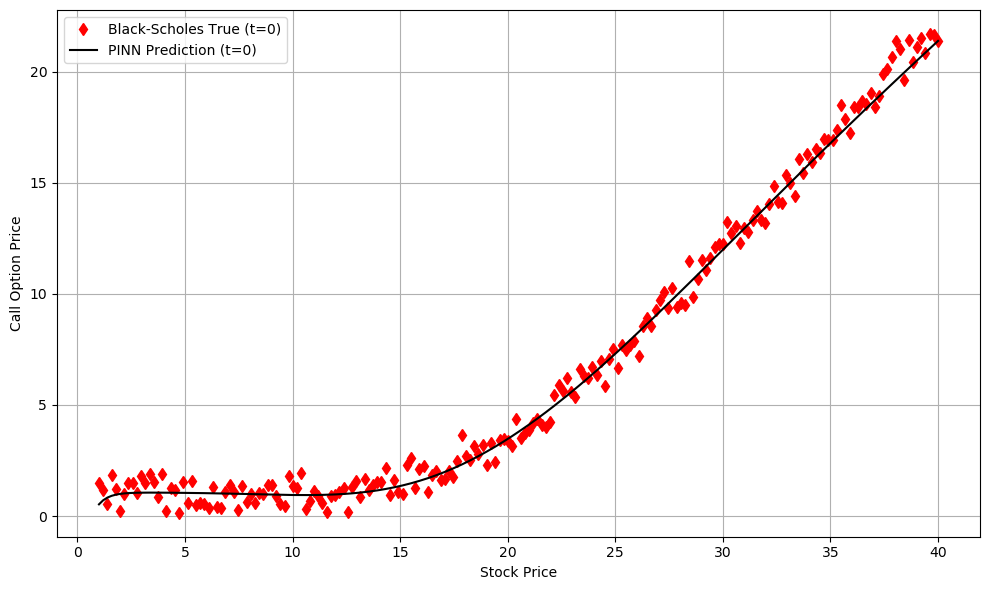

In [4]:
S_np = S_eval.numpy().flatten()
C_true = black_scholes_solution(S_np, config["K"], config["T"], config["r"], config["sigma"]) + config["bias"]
C_true += np.random.normal(0, config["noise_variance"], size=C_true.shape)
plt.figure(figsize=(10, 6))
plt.plot(S_np, C_true, 'd', label="Black-Scholes True (t=0)",color='red')
plt.plot(S_np, C_pred, label="PINN Prediction (t=0)", color='k')
plt.xlabel('Stock Price')
plt.ylabel('Call Option Price')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()